In [1]:
import os, glob
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

import pandas as pd

from astropy.nddata import CCDData
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Tophat2DKernel as Kernel

import ccdproc

from util import *

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}


# Extract the Signal

In [3]:
data_path = os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "calib")
overwrite = False

if overwrite:
    wcs_data_path = os.path.join(data_path, "*WCS*")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]

    print("Done reading in data, starting to clean the chip gap...")

    fig = plt.figure()
    for ii, d in enumerate(wcs_data):

        print(f'Working on {d.meta["FILTER"]}')
        # smooth over the chip gap because it's annoying
        kernel = Kernel(9)
        wcs_data[ii].data = interpolate_replace_nans(d.data, kernel)

        # plot all the images to make sure the chip gap looks okay
        img = wcs_data[ii]
        wcs = img.wcs
        print(ii)
        ax = fig.add_subplot(2,2,ii+1) 

        ax.imshow(
            img.data,
            origin="lower",
            norm=simple_norm(
                data=img.data,
                stretch="linear",
                **norm_kwargs[img.meta["FILTER"]]
            ),
            cmap="gray"
        )

        wcs_data[ii].write(wcs_data_files[ii].replace(".fits", ".NOCHIPGAP.fits"), overwrite=overwrite)
        
else:
    # we can just read in the ones previously computed, cause this takes a while
    wcs_data_path = os.path.join(data_path, "*WCS.NOCHIPGAP.fits")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]


{'Harris-V': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 686.6747350069558 707.9193545467556 525131.3793059962,
 'Bessell-U': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 691.2074200169961 709.6860327014286 95118.46286892914,
 'Harris-B': <QTable length=1>
   id       xcenter           ycenter         aperture_sum   
              pix               pix               adu        
 int64      float64           float64           float64      
 ----- ----------------- ----------------- ------------------
     1 692.4297288520879 704.3353420770002 352

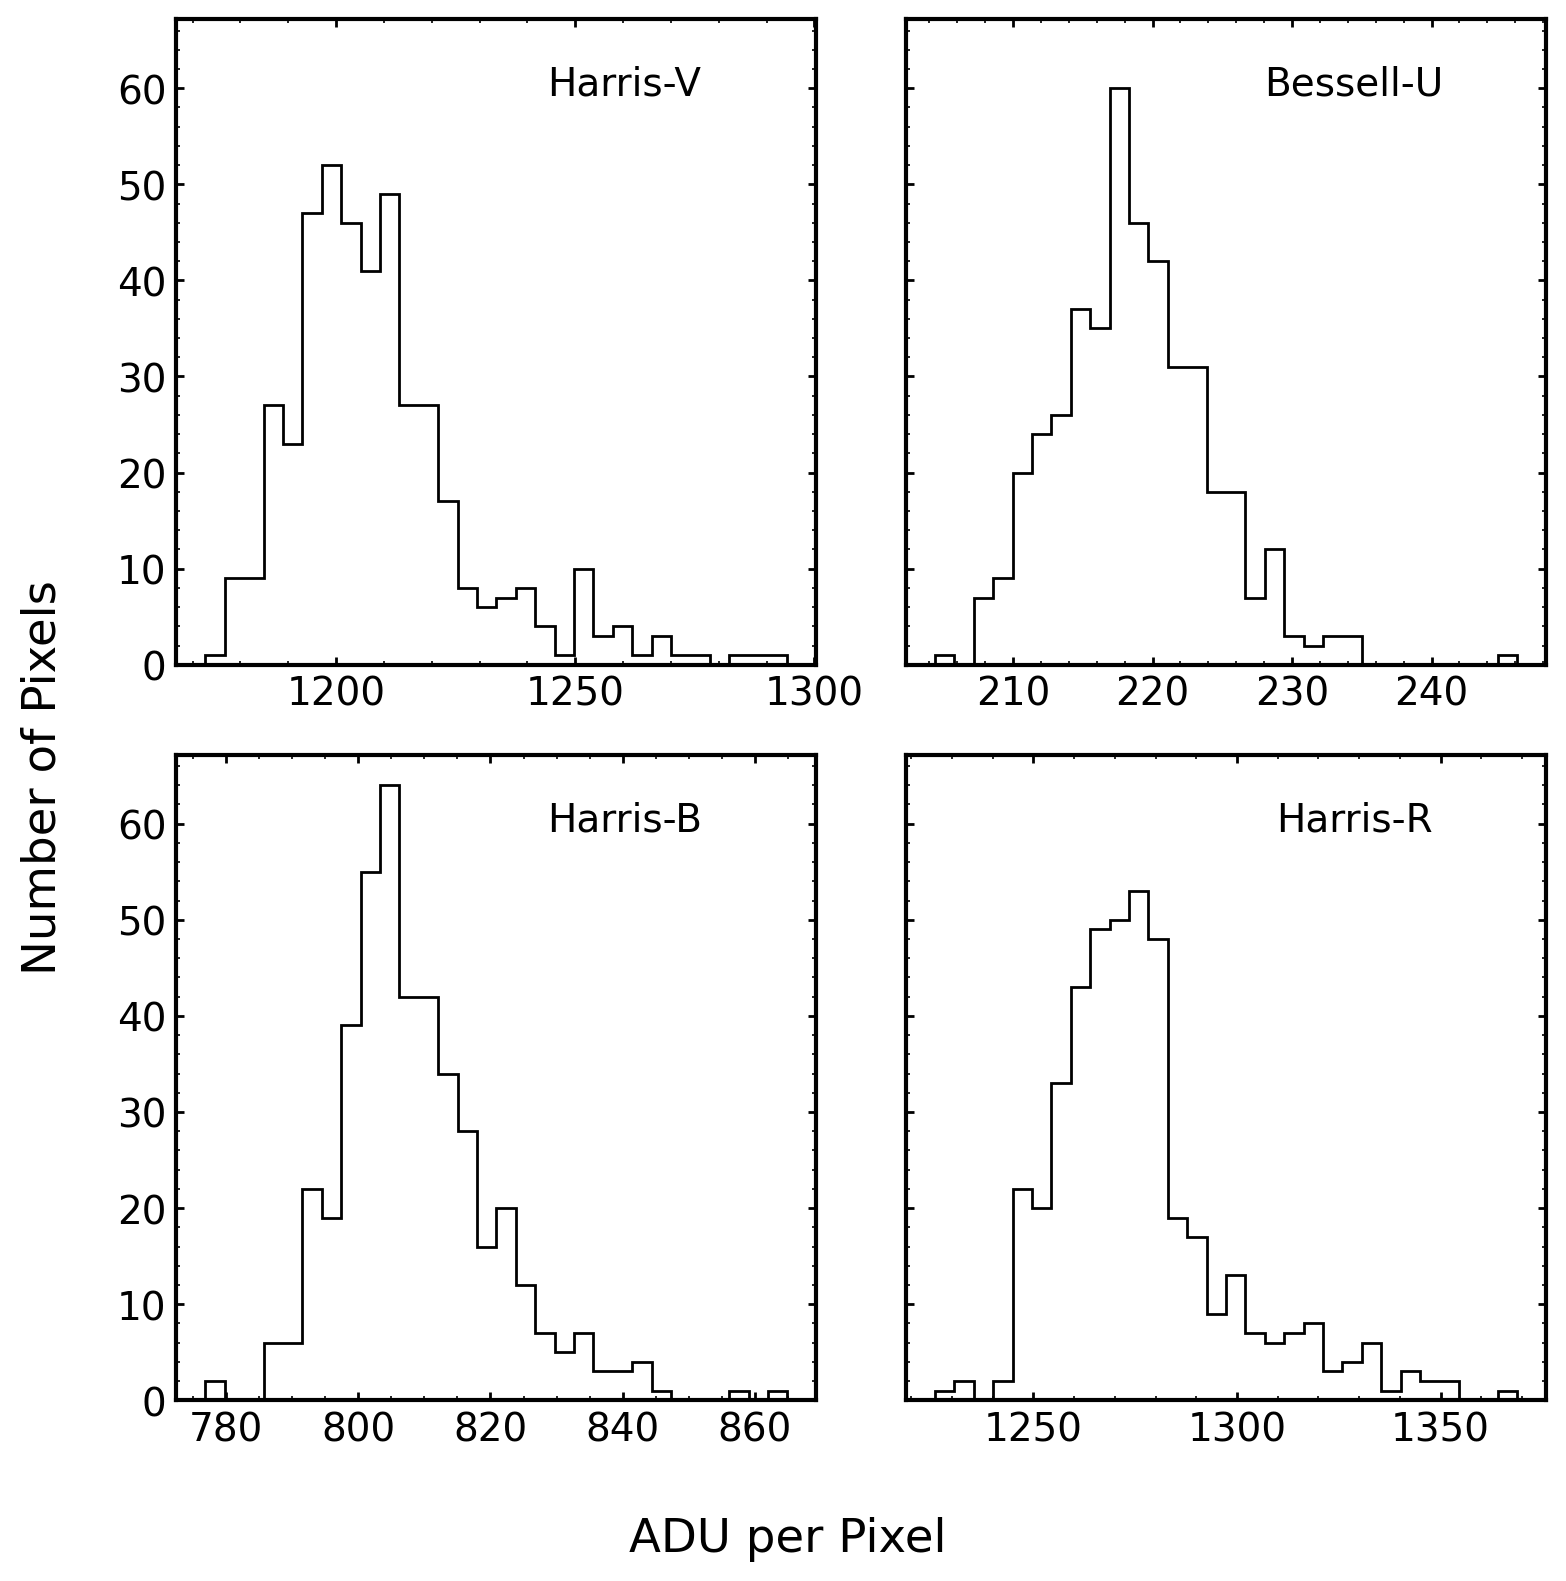

In [4]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)
apertures = [aperture.to_pixel(d.wcs) for d in wcs_data]
kuiper = Kuiper(apertures[0].r)
res = {v[0].meta["FILTER"]: aperture_photometry(*v) for v in zip(wcs_data, apertures)}

# plot the histograms of the counts/pixel within the aperture
fig, axs = plt.subplots(2,2,sharey=True,figsize=(8,8))
for img, a, ax in zip(wcs_data, apertures, axs.flatten()):

    y, x = np.indices(img.data.shape)
    center_x, center_y = a.positions
    mask = (x - center_x)**2 + (y - center_y)**2 <= a.r**2
    within_aper = img.data[mask].flatten()
    ax.hist(within_aper, bins=30, histtype="step", color='k')
    ax.text(
        0.7, 0.9, img.meta["FILTER"],
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes
    )

fig.supxlabel("ADU per Pixel")
fig.supylabel("Number of Pixels")

fig.savefig("aperture-counts-hist.png")

res

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


/tmp/ipykernel_1591269/263819093.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig("target-images.png", transparent=False)


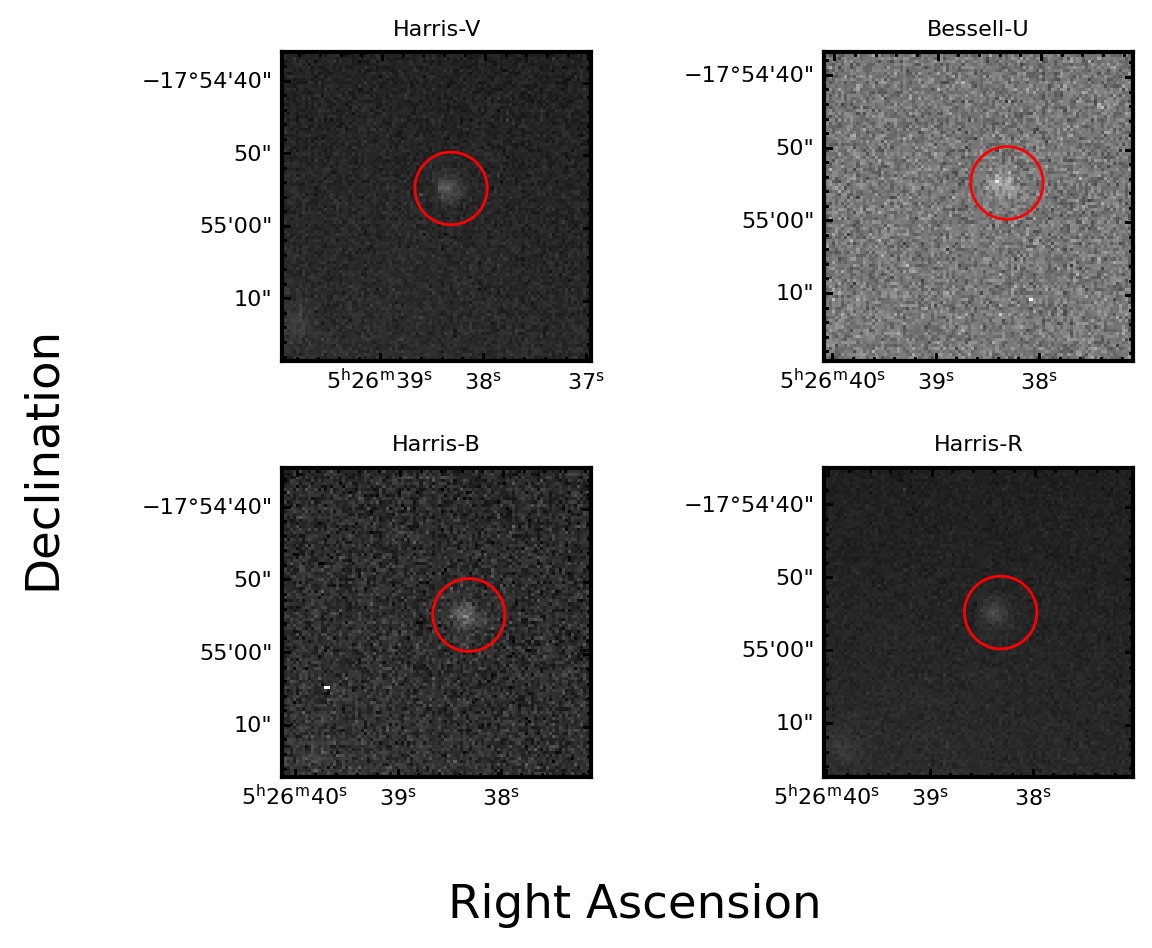

In [5]:
fs = 8
ms = 500
fig = plt.figure()

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    aper = a.to_sky(wcs)
    print(aper.positions)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    # ax.scatter_coord(pos, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    dx = dy = 50
    midx = img.data.shape[0]//2
    midy = img.data.shape[0]//2 + 20
    xlim = (midx-dx, midx+dx)
    ylim = (midy-dy, midy+dy)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

fig.savefig("target-images.png", transparent=False)

In [6]:
res_to_stack = []
for k, row in res.items():
    row["FILTER"] = k
    row["aperture_sum_e"] = row["aperture_sum"] * kuiper.gain
    row["aperture_sum_photons"] = row["aperture_sum_e"] * kuiper.electron_to_photons
    
    res_to_stack.append(row)
    
data = vstack(res_to_stack).to_pandas()
data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons
0,1,686.674735,707.919355,525131.379306,Harris-V,1.627907e+06,2.711100e+06
1,1,691.207420,709.686033,95118.462869,Bessell-U,2.948672e+05,4.910689e+05
2,1,692.429729,704.335342,352222.452220,Harris-B,1.091890e+06,1.818422e+06
3,1,689.190232,705.135714,554880.183509,Harris-R,1.720129e+06,2.864685e+06


# Sky Background Noise

Put a bunch of apertures on the background of the images and median them

In [7]:
from astropy.stats import SigmaClip
from photutils.background import LocalBackground, SExtractorBackground

all_bckgd = dict(
    FILTER = [],
    bckgd_adu = [],
    bckgd_err_adu = []
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)

for img in wcs_data:
    bkg = LocalBackground(
        inner_radius=kuiper.aperture_radius,
        outer_radius=2*kuiper.aperture_radius,
        bkg_estimator=SExtractorBackground(SigmaClip(sigma=3))
    )

    aper = aperture.to_pixel(img.wcs)

    bkg_res = bkg(img.data, *aper.positions)*kuiper.npix
    
    all_bckgd["FILTER"].append(img.header["FILTER"])
    all_bckgd["bckgd_adu"].append(bkg_res)
    all_bckgd["bckgd_err_adu"].append(np.sqrt(bkg_res))

bckgd_df = pd.DataFrame(all_bckgd)
bckgd_df["bckgd_e"] = bckgd_df.bckgd_adu*kuiper.gain
bckgd_df["bckgd_err_e"] = bckgd_df.bckgd_err_adu*kuiper.gain
bckgd_df["bckgd_photons"] = bckgd_df.bckgd_e*kuiper.electron_to_photons
bckgd_df["bckgd_err_photons"] = bckgd_df.bckgd_err_e*kuiper.electron_to_photons

data = pd.merge(data, bckgd_df, on="FILTER")

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons
0,1,686.674735,707.919355,525131.379306,Harris-V,1.627907e+06,2.711100e+06,521430.411530,722.101386,1.616434e+06,2238.514296,2.691993e+06,3727.999028
1,1,691.207420,709.686033,95118.462869,Bessell-U,2.948672e+05,4.910689e+05,94325.439151,307.124468,2.924089e+05,952.085852,4.869748e+05,1585.594132
2,1,692.429729,704.335342,352222.452220,Harris-B,1.091890e+06,1.818422e+06,348674.985160,590.487075,1.080892e+06,1830.509931,1.800107e+06,3048.512692
3,1,689.190232,705.135714,554880.183509,Harris-R,1.720129e+06,2.864685e+06,549048.015091,740.977743,1.702049e+06,2297.031002,2.834575e+06,3825.452157


# Background Subtraction

Now, we need to subtract the background from the signal (ie. the aperture sum) in both e and photons. This is so we can get a SNR estimate from the electrons aperture sum and then, finally, convert the aperture sum in photons to usable units.

In [8]:
data["signal_e"] = data.aperture_sum_e - data.bckgd_e
data["signal_photons"] = data.aperture_sum_photons - data.bckgd_photons

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons
0,1,686.674735,707.919355,525131.379306,Harris-V,1.627907e+06,2.711100e+06,521430.411530,722.101386,1.616434e+06,2238.514296,2.691993e+06,3727.999028,11473.000106,19107.018129
1,1,691.207420,709.686033,95118.462869,Bessell-U,2.948672e+05,4.910689e+05,94325.439151,307.124468,2.924089e+05,952.085852,4.869748e+05,1585.594132,2458.373526,4094.150362
2,1,692.429729,704.335342,352222.452220,Harris-B,1.091890e+06,1.818422e+06,348674.985160,590.487075,1.080892e+06,1830.509931,1.800107e+06,3048.512692,10997.147887,18314.538665
3,1,689.190232,705.135714,554880.183509,Harris-R,1.720129e+06,2.864685e+06,549048.015091,740.977743,1.702049e+06,2297.031002,2.834575e+06,3825.452157,18079.722095,30109.785990


# Dark Noise

Estimate the dark noise by reading in the darks and then summing all of the values in them

18.866327046227983 electron / (h pix) 4.343538539742451 electron(1/2) / (h(1/2) pix(1/2))


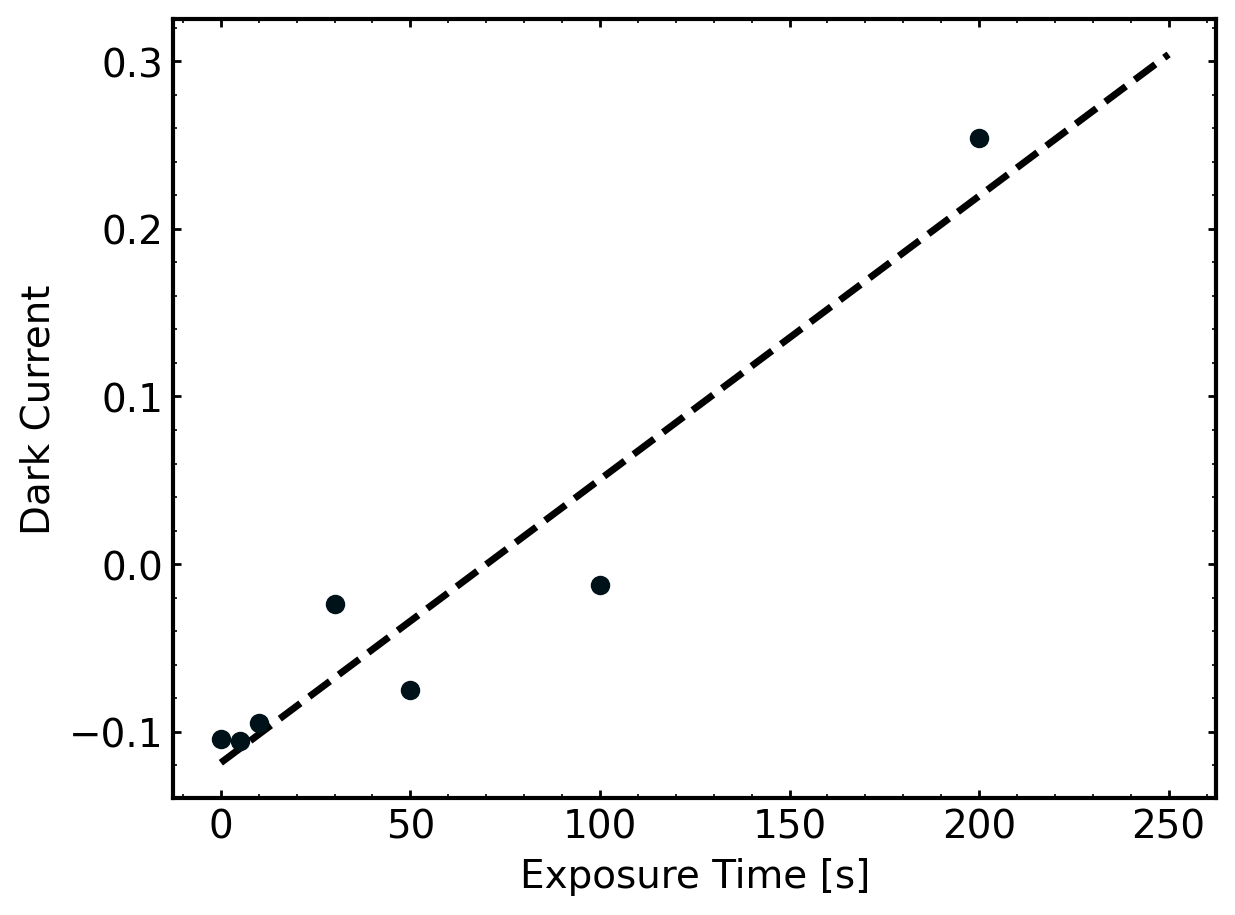

In [9]:
# read in all of the individual darks

combined_bias = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_BIAS.fits")
)

darks = glob.glob(os.path.join(os.environ["HOME"], "instrumentation_project", "astr518_2024kuiper_night1", "*DARK*"))
exptime_dict = {}
for f in darks:
    if "ewantest" in f: continue
    if "franz.DARK" in f: continue
    d = CustomCCDData.read(f)
    exptime = d.meta["EXPTIME"]
    if str(exptime) not in exptime_dict:
        exptime_dict[str(exptime)] = [d]
    else:
        exptime_dict[str(exptime)].append(d)

exptimes, dark_noise, dark_noise_err = [], [], []
for exptime, darks in exptime_dict.items():
    exptimes.append(float(exptime))
    bias_subtracted_darks = [
        ccdproc.subtract_bias(d, combined_bias) for d in darks
    ]
    d = ccdproc.combine(bias_subtracted_darks, **ccdp_combine_kwargs).data
    dark_noise.append(np.mean(d))
    dark_noise_err.append(np.std(d))

fig, ax = plt.subplots()

ax.errorbar(exptimes, dark_noise, marker='o', linestyle='none', capsize=5)

p = np.polyfit(exptimes, dark_noise, 1)
x = np.linspace(0, 250)
y = np.polyval(p, x)
ax.plot(x,y,linestyle='--',color='k')

ax.set_ylabel("Dark Current")
ax.set_xlabel("Exposure Time [s]")

fig.savefig("dark_current.png")

dark_rate = (p[0]*u.adu/u.s/u.pixel).to(u.adu/u.hr/u.pixel) * kuiper.gain
print(dark_rate, np.sqrt(dark_rate))

exptime = 50 # seconds
data["dark_noise_adu"] = np.sqrt(p[0]*exptime)
data["dark_noise_e"] = np.sqrt(p[0]*kuiper.gain*exptime)


# Read Noise

Estimate the read noise from the bias images

In [10]:
bias_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_BIAS.fits")
)

files = ReductionFiles(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data"))
files.read_and_organize("AT2024wsd")
bias_data = [CustomCCDData.read(bias_file) for bias_file in files.bias_files["none"]]

rn = []
for _ in range(100):
    rng_choice = np.random.choice(len(bias_data))
    read_noise = ccdproc.subtract_bias(bias_combined, bias_data[rng_choice])    
    rn.append(read_noise)
    
read_noise_adu = np.nanstd(rn)

data["read_noise_adu"] = read_noise_adu
data["read_noise_e"] = kuiper.gain * read_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e
0,1,686.674735,707.919355,525131.379306,Harris-V,1.627907e+06,2.711100e+06,521430.411530,722.101386,1.616434e+06,2238.514296,2.691993e+06,3727.999028,11473.000106,19107.018129,0.290735,0.511891,3.258357,10.100908
1,1,691.207420,709.686033,95118.462869,Bessell-U,2.948672e+05,4.910689e+05,94325.439151,307.124468,2.924089e+05,952.085852,4.869748e+05,1585.594132,2458.373526,4094.150362,0.290735,0.511891,3.258357,10.100908
2,1,692.429729,704.335342,352222.452220,Harris-B,1.091890e+06,1.818422e+06,348674.985160,590.487075,1.080892e+06,1830.509931,1.800107e+06,3048.512692,10997.147887,18314.538665,0.290735,0.511891,3.258357,10.100908
3,1,689.190232,705.135714,554880.183509,Harris-R,1.720129e+06,2.864685e+06,549048.015091,740.977743,1.702049e+06,2297.031002,2.834575e+06,3825.452157,18079.722095,30109.785990,0.290735,0.511891,3.258357,10.100908


# Computing the Signal to Noise Ratio

In [11]:
data.signal_e / data.bckgd_err_e

0    5.125274
1    2.582092
2    6.007696
3    7.870909
dtype: float64

In [12]:
data["noise"] = np.sqrt(data.signal_e + data.bckgd_e + kuiper.npix*data.read_noise_e**2 + (kuiper.npix*data.dark_noise_e)**2)
data["SNR"] = data.signal_e / data.noise

data[["FILTER", "SNR"]]

,FILTER,SNR
0,Harris-V,8.743863
1,Bessell-U,3.943534
2,Harris-B,10.099579
3,Harris-R,13.424168


# Converting to physical units (Zero Point Calibration)

Now that we have the data background subtracted and SNR computed, we need to convert from photons to physical units. I do this by finding another star in the field and computing a ratio of photons to magnitudes

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,...,signal_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e,noise,SNR,zero_point,mag,mag_err
0,1,686.674735,707.919355,525131.379306,Harris-V,1.627907e+06,2.711100e+06,521430.411530,722.101386,1.616434e+06,...,19107.018129,0.290735,0.511891,3.258357,10.100908,1312.120274,8.743863,4.709496e+11,18.479454,2.113420
1,1,691.207420,709.686033,95118.462869,Bessell-U,2.948672e+05,4.910689e+05,94325.439151,307.124468,2.924089e+05,...,4094.150362,0.290735,0.511891,3.258357,10.100908,623.393593,3.943534,5.001514e+10,17.717344,4.492759
2,1,692.429729,704.335342,352222.452220,Harris-B,1.091890e+06,1.818422e+06,348674.985160,590.487075,1.080892e+06,...,18314.538665,0.290735,0.511891,3.258357,10.100908,1088.871865,10.099579,3.312906e+11,18.143533,1.796464
3,1,689.190232,705.135714,554880.183509,Harris-R,1.720129e+06,2.864685e+06,549048.015091,740.977743,1.702049e+06,...,30109.785990,0.290735,0.511891,3.258357,10.100908,1346.803960,13.424168,4.448183e+11,17.923688,1.335181


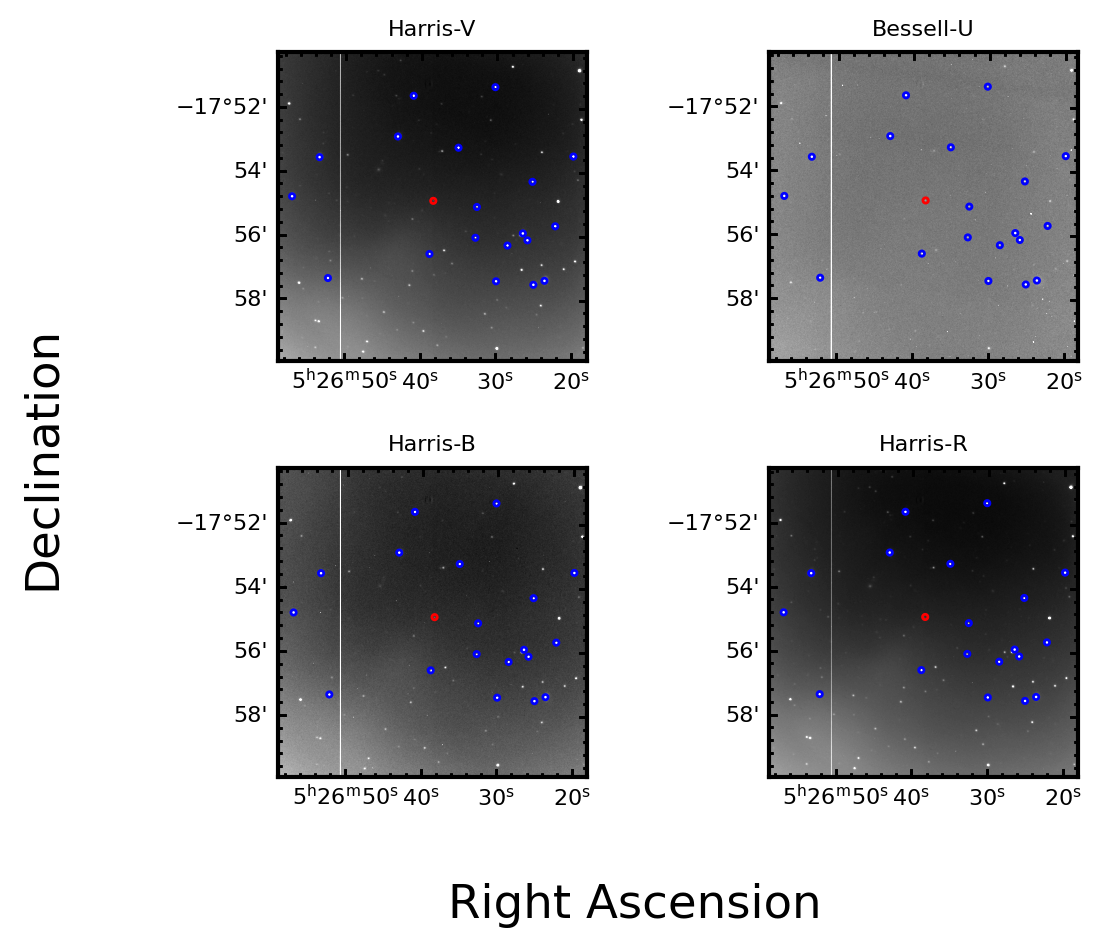

In [13]:
from astroquery.vizier import Vizier

# this information comes from drawing a circle over most of the image in DS9
center = SkyCoord(
    "5:26:38.2737",
    "-17:55:03.793",
    unit=("hour", "deg")
)

radius = "282 arcsec"

# now use it to query Vizier
vizier = Vizier(columns=["Source", "RA_ICRS", "DE_ICRS", "Bmag", "Rmag", "Vmag", "Umag"])
res = vizier.query_region(center, radius=radius, catalog="I/360/syntphot")[0].to_pandas()
res = res.dropna()

fig = plt.figure()
derived_zero_points = {}
radius = 5*u.arcsec

filt_key_map = {
    "Harris-V" : "Vmag",
    "Harris-R" : "Rmag",
    "Harris-B" : "Bmag",
    "Bessell-U": "Umag"
}

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    mag_key = filt_key_map[img.meta["FILTER"]]
    
    # compute the conversion factor
    # 1) measure the aperture sum for each of the field stars 
    positions = SkyCoord(res.RA_ICRS, res.DE_ICRS, unit="deg", frame="icrs")
    sky_aperture = SkyCircularAperture(positions, radius)
    pix_aperture = sky_aperture.to_pixel(wcs)
    df = aperture_photometry(img, pix_aperture).to_pandas()

    # 2) subtract out the background using an annulus (same method as before)
    bkg = LocalBackground(
        inner_radius=kuiper.aperture_radius,
        outer_radius=2*kuiper.aperture_radius,
        bkg_estimator=SExtractorBackground(SigmaClip(sigma=3))
    )
    df["bkg_sum"] = [bkg(img.data, *a.positions)*kuiper.npix for a in pix_aperture]
    df["signal_adu"] = df.aperture_sum - df.bkg_sum
    
    # 3) convert things appropriately and calculate the conversion factor
    df["aperture_sum_e"] = df.signal_adu * kuiper.gain
    df["aperture_sum_photons"] = df.aperture_sum_e * kuiper.electron_to_photons
    df[mag_key] = list(res[mag_key])
    derived_zero_points[img.meta["FILTER"]] = list(df.aperture_sum_photons*10**(0.4*df[mag_key]))
    
    # plot all of these objects
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    aper = a.to_sky(wcs)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)

    for _,row in res.iterrows():
            circ = SphericalCircle(
                SkyCoord(row.RA_ICRS, row.DE_ICRS, unit="deg", frame="icrs"),
                aper.r,
                edgecolor='blue',
                facecolor='none',
                transform=ax.get_transform('fk5')
            )
            ax.add_patch(circ)

    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
        
    ax.set_title(img.meta["FILTER"], fontsize=fs)

fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

fig.savefig("fcal-images.png", transparent=False)
    
data["zero_point"] = [np.median(derived_zero_points[f]) for f in data.FILTER]
data["mag"] = -2.5*np.log10(data.signal_photons / data.zero_point)

data["mag_err"] = (data.noise*kuiper.electron_to_photons) * (data.mag/data.signal_photons)

data

In [14]:
# save the reduced dataset to a csv
data.to_csv("reduced-photometry.csv")